# Dashboard
* This notebook contains visualiations that could be incorporated into the final dashboard
* "Could your grandmother understand these visualizations?"

In [1]:
import ast
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import regex as re
import seaborn as sns

from dateutil.relativedelta import relativedelta
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import chi2_contingency, mannwhitneyu

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from ipywidgets import widgets
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import json
import copy

## 0. Import and preprocess

In [2]:
# Import and join docket and court summary csv files
docketdf = pd.read_csv("docket-parsed.csv", index_col=0)
courtdf = pd.read_csv("court-parsed.csv", index_col=0)
df = docketdf.merge(courtdf, on='docket_no', how='left', suffixes=('', '_y'))
df.reset_index(inplace=True)
df.drop(columns=['docket_no'], inplace=True)
df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
df.head()

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,bail_type,dob,zip,arresting_officer,case_status,arrest_dt,prelim_hearing_dt,prelim_hearing_time,sex,race
0,Defender Association of Philadelphia,Public,['DUI: Gen Imp/Inc of Driving Safely - 1st Off...,12/31/2019,"['75 § 3802', '75 § 3323']",['driving after imbibing alcohol or utilizing ...,"Bernard, Francis X.",0.0,0.0,01/01/2020,ROR,04/06/1994,19115,"Jimenez Gonzalez, Edgardo",Active,01/01/2020,01/01/2020,4:05 am,Male,White
1,Joseph Kevin Kelly,Private,['DUI: Gen Imp/Inc of Driving Safely - 1st Off'],12/31/2019,['75 § 3802'],['driving after imbibing alcohol or utilizing ...,"Bernard, Francis X.",0.0,0.0,01/01/2020,ROR,12/24/1995,19134,"Fuentes, Kristina",Active,01/01/2020,01/01/2020,4:07 am,Male,White
2,Defender Association of Philadelphia,Public,['Retail Theft-Take Mdse'],12/31/2019,['18 § 3929'],['theft and related offenses'],"Bernard, Francis X.",0.0,0.0,01/01/2020,ROR,09/30/1962,19131,"Castro-Baez, Geovanny",Adjudicated,12/31/2019,01/01/2020,4:10 am,Male,Black
3,Defender Association of Philadelphia,Public,"['Simple Assault', 'Recklessly Endangering Ano...",12/31/2019,"['18 § 2701', '18 § 2705']","['assault', 'assault']","Bernard, Francis X.",30000.0,0.0,01/01/2020,Monetary,10/04/1987,19121,"Rios, Christina",Active,12/31/2019,01/01/2020,4:15 am,Male,Black
4,Lee Mandell,Court Appointed,"['Robbery-Inflict Threat Imm Bod Inj', 'Conspi...",12/31/2019,"['18 § 3701 §§ A1IV', '18 § 903 §§ C', '18 § 3...","['robbery', 'inchoate crimes', 'theft and rela...","Pittman, Joffie C. III",30000.0,0.0,01/09/2020,Unsecured,04/23/2001,19135-3509,Affiant,Closed,01/01/2020,01/01/2020,8:39 am,Male,Black


In [3]:
# Note: will need to change _dt to _date for column headings in new data

# convert string to datetime
#df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = df["prelim_hearing_dt"].apply(lambda x: str(x).split(' ')[0] if pd.notnull(x) else x)
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])
df["prelim_hearing_time"] = pd.to_datetime(df["prelim_hearing_time"])

# age column
#df['age'] = df['dob'].apply(lambda x: 2020-x.year)
df['age'] = df['arrest_dt'] - df['dob']
df['age'] = df['age'].apply(lambda x: np.floor(x.days/365.2425))

# public defender column: 1 if public defender, 0 if private defender
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert type of "offenses" and "parsed_offenses" from string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
#df["parsed_offenses"] = df["parsed_offenses"].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# Create column indicating whether zipcode is in philadelphia or not
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

In [4]:
# remove arrests that occurred between 5/31 - 6/3 (BLM movement)
df = df[(df['arrest_dt'] < np.datetime64('2020-05-31')) | (df['arrest_dt'] > np.datetime64('2020-06-03'))]

In [5]:
df.head()

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,case_status,arrest_dt,prelim_hearing_dt,prelim_hearing_time,sex,race,age,public_defender,zipcode_clean,philly_zipcode
0,Defender Association of Philadelphia,Public,"[DUI: Gen Imp/Inc of Driving Safely - 1st Off,...",12/31/2019,"['75 § 3802', '75 § 3323']",['driving after imbibing alcohol or utilizing ...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,Active,2020-01-01,2020-01-01,2020-12-05 04:05:00,Male,White,25.0,0,19115,1
1,Joseph Kevin Kelly,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],12/31/2019,['75 § 3802'],['driving after imbibing alcohol or utilizing ...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,Active,2020-01-01,2020-01-01,2020-12-05 04:07:00,Male,White,24.0,0,19134,1
2,Defender Association of Philadelphia,Public,[Retail Theft-Take Mdse],12/31/2019,['18 § 3929'],['theft and related offenses'],"Bernard, Francis X.",0.0,0.0,2020-01-01,...,Adjudicated,2019-12-31,2020-01-01,2020-12-05 04:10:00,Male,Black,57.0,0,19131,1
3,Defender Association of Philadelphia,Public,"[Simple Assault, Recklessly Endangering Anothe...",12/31/2019,"['18 § 2701', '18 § 2705']","['assault', 'assault']","Bernard, Francis X.",30000.0,0.0,2020-01-01,...,Active,2019-12-31,2020-01-01,2020-12-05 04:15:00,Male,Black,32.0,0,19121,1
4,Lee Mandell,Court Appointed,"[Robbery-Inflict Threat Imm Bod Inj, Conspirac...",12/31/2019,"['18 § 3701 §§ A1IV', '18 § 903 §§ C', '18 § 3...","['robbery', 'inchoate crimes', 'theft and rela...","Pittman, Joffie C. III",30000.0,0.0,2020-01-09,...,Closed,2020-01-01,2020-01-01,2020-12-05 08:39:00,Male,Black,18.0,0,19135,1


## 1. Aggregate bail information for the year 2020

Total number of cases analyzed (excluding 5/31 - 6/3): 20,426
Monetary       8744
ROR            5627
Unsecured      5599
Nonmonetary     122
Nominal           4
Name: bail_type, dtype: int64
-> Monetary bail set in 42.8% of cases

Total bail set: $1,121,468,796.0
Total bail paid: $19,638,385.0


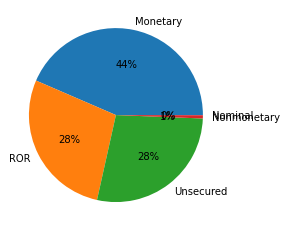

In [6]:
# Total cases, distribution of bail set
totalCases = len(df.index)
print("Total number of cases analyzed (excluding 5/31 - 6/3): {0:,}".format(totalCases))

# Bail type distribution
df_bail = df['bail_type'].value_counts()
print(df_bail)
bailTypes = df_bail.keys().tolist()
bailTypeCounts = df_bail.values

plt.pie(bailTypeCounts, labels=bailTypes, autopct='%1.0f%%')

# Total amount of bail set
df_monetary = df[df['bail_type'] == "Monetary"]
totalBailSet = df['bail_amount'].sum()
totalBailPaid = df['bail_paid'].sum()
print("-> Monetary bail set in {0:.1f}% of cases".format(100*df_bail["Monetary"]/totalCases))
print("\nTotal bail set: ${0:,}".format(totalBailSet))
print("Total bail paid: ${0:,}".format(totalBailPaid))

### Below is just the above reproduced in a sample interactive viz where one can use the slider to select a range of dates. Not sure how to incorporate the distribution of bail types yet.

*Also not sure whether `bail_date` or another date field should be used

In [7]:
# Get start/end dates for date range to be used in slider
start_date = df['bail_date'].min()
end_date = df['bail_date'].max()
dates = pd.date_range(start_date, end_date, freq='D')

In [9]:
# Turn dates into options on slider
options = [(date.strftime('%d %b %Y'), date) for date in dates]
index = (0, len(options)-1)

# Date range slider
select_date = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '550px'}
)

# Card for Case Count
cases = go.Indicator(
    mode = 'number',
    value = len(df),
    domain = {'row': 0, 'column': 0 }, 
    title = {'text': 'Total Cases'})

# Card for Monetary Bail Frequency
frequency = go.Indicator(
    mode = 'number',
    value = len(df[df['bail_type'] == 'Monetary']) / len(df) * 100.,
    number = {'suffix': '%'},
    domain = {'row': 0, 'column': 1 }, 
    title = {'text': 'Monetary Bail Frequency'})

# Card for Total Bail Amt
amount = go.Indicator(
    mode = 'number',
    value = df['bail_amount'].sum(),
    number = {'prefix': '$'},
    domain = {'row': 1, 'column': 0 }, 
    title = {'text': 'Total Bail Set'})

# Card for Total Bail Paid
paid = go.Indicator(
    mode = 'number',
    value = df['bail_paid'].sum(),
    number = {'prefix': '$'},
    domain = {'row': 1, 'column': 1 }, 
    title = {'text': 'Total Bail Paid'})

# Set up figure as 2x2 grid of the cards in the order specified
card_fig = go.FigureWidget()
card_fig.add_trace(cases)
card_fig.add_trace(frequency)
card_fig.add_trace(amount)
card_fig.add_trace(paid)
card_fig.update_layout(
    grid = {'rows': 2, 'columns': 2, 'pattern': "independent"})

# Function that updates each card based on the new date range selected on slider
def response(change):
    # New date range and filter df
    start, end = select_date.value[0], select_date.value[1]
    tmp = df[(df['bail_date'] >= start)&(df['bail_date'] <= end)]
    
    # Update values for each card
    card_fig.data[0].value = len(tmp)
    card_fig.data[1].value = len(tmp[tmp['bail_type'] == 'Monetary']) / len(tmp) * 100.
    card_fig.data[2].value = tmp['bail_amount'].sum()
    card_fig.data[3].value = tmp['bail_paid'].sum()

# Set up date range slider to update cards
select_date.observe(response, names='value')

widgets.VBox([select_date, card_fig])

## 2. Visualizations on magistrate information

### 2.1 Select magistrates to include in the analysis  
* Out of 612 magistrates in data, select magistrates to analyze

In [6]:
print('Total number of magistrates: ', len(df['bail_set_by'].value_counts()))

Total number of magistrates:  612


<b> Total number of cases handled by each magistrate </b>

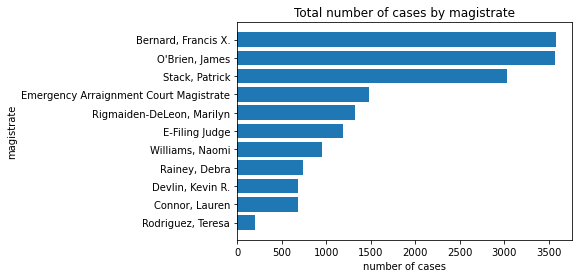

In [7]:
n_magistrates = 11
plt.barh(df['bail_set_by'].value_counts()[:n_magistrates].keys()[::-1], df['bail_set_by'].value_counts()[:n_magistrates].values[::-1])
plt.xlabel('number of cases')
plt.ylabel('magistrate')
plt.title('Total number of cases by magistrate')
plt.show()

In [8]:
df_magistrate = pd.crosstab(index = df['bail_set_by'], columns =df['bail_type'])
# note: total excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)
print('Total number of magistrates (with valid bail type): {0}'.format(len(df_magistrate.index)))

Total number of magistrates (with valid bail type): 610


In [9]:
# Magistrates that were involved in more than caseFloor cases
caseFloor = 175
magistrates = df_magistrate[df_magistrate['Total'] > caseFloor].index
print("Number of magistrates with more than {0} cases: {1}".format(caseFloor, len(magistrates)))

Number of magistrates with more than 175 cases: 12


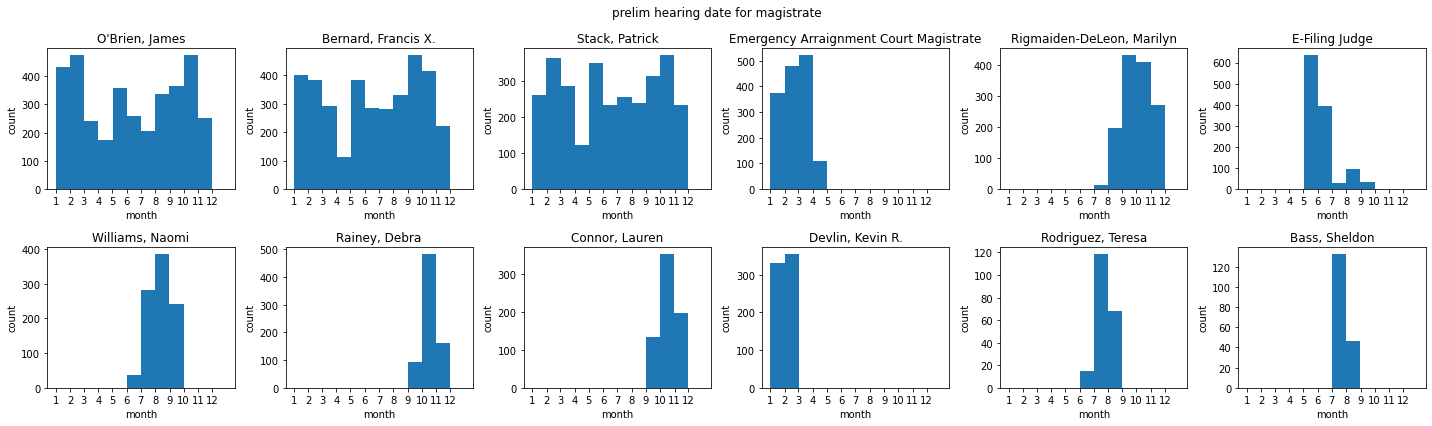

In [11]:
# get date ranges
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2020, 12, 31)
delta = relativedelta(months = 1)
date_range = []

while start_date <= end_date:
    date_range.append(start_date)
    start_date += delta

# plot
fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 6))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing date for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 6
    col = idx % 6
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_dt, bins = 12, range = (datetime.date(2020,1,1), datetime.date(2020, 12 ,31)))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xticks(date_range)
    sub.set_xticklabels([item.month for item in date_range])
    sub.set_xlabel('month')
    sub.set_ylabel('count')
plt.tight_layout()
plt.show()

* 'Emergency Arraignment Court Magistrate' and 'E-Filing Judge' are probably the same entity.
    * Are they filed under a different name starting October? Not sure why we don't see 'E-Filing Judge' after October
* There are a few people (Riamaiden-DeLeon, Williams, Rainey, Connor, Devlin, Rodriguez) that were involved in part of the year. 


In [12]:
# Correct 'Emergency Arraignment Court Magistrate' to 'E-Filing Judge'
df['bail_set_by'] = df['bail_set_by'].apply(lambda x: 'E-Filing Judge' if x == 'Emergency Arraignment Court Magistrate' else x)

In [13]:
# selected magistrates 
magistrates = ['Bernard, Francis X.', 
               "O'Brien, James", 
               'Stack, Patrick', 
               'Rigmaiden-DeLeon, Marilyn',
               'E-Filing Judge', 
               'Williams, Naomi',
               'Rainey, Debra', 
               'Connor, Lauren', 
               'Devlin, Kevin R.']
print("Selected magistrates: ")
for name in magistrates:
    print(name)

Selected magistrates: 
Bernard, Francis X.
O'Brien, James
Stack, Patrick
Rigmaiden-DeLeon, Marilyn
E-Filing Judge
Williams, Naomi
Rainey, Debra
Connor, Lauren
Devlin, Kevin R.


In [14]:
# select core magistrates
core_magistrates = ['Bernard, Francis X.', 'Rigmaiden-DeLeon, Marilyn', "O'Brien, James", 'Stack, Patrick', 'E-Filing Judge']
print("Selected core magistrates: ")
for name in core_magistrates:
    print(name)

Selected core magistrates: 
Bernard, Francis X.
Rigmaiden-DeLeon, Marilyn
O'Brien, James
Stack, Patrick
E-Filing Judge


### 2.2 Are bail type and magistrate correlated?

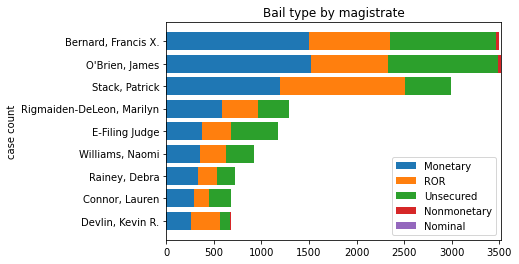

In [15]:
monetary = df_magistrate['Monetary'][magistrates].values[::-1]
ROR = df_magistrate['ROR'][magistrates].values[::-1]
Unsecured = df_magistrate['Unsecured'][magistrates].values[::-1]
Nonmonetary = df_magistrate['Nonmonetary'][magistrates].values[::-1]
Nominal = df_magistrate['Nominal'][magistrates].values[::-1]
ind = range(len(magistrates))

plt.barh(ind, monetary)
plt.barh(ind, ROR, left = monetary)
plt.barh(ind, Unsecured, left = monetary + ROR)
plt.barh(ind, Nonmonetary, left = monetary + ROR + Unsecured)
plt.barh(ind, Nominal, left = monetary + ROR + Unsecured + Nonmonetary)
plt.legend(labels = ['Monetary', 'ROR', 'Unsecured', 'Nonmonetary', 'Nominal'])
plt.ylabel('magistrate')
plt.yticks(ind, magistrates[::-1])
plt.ylabel('case count')
plt.title('Bail type by magistrate')
plt.show()

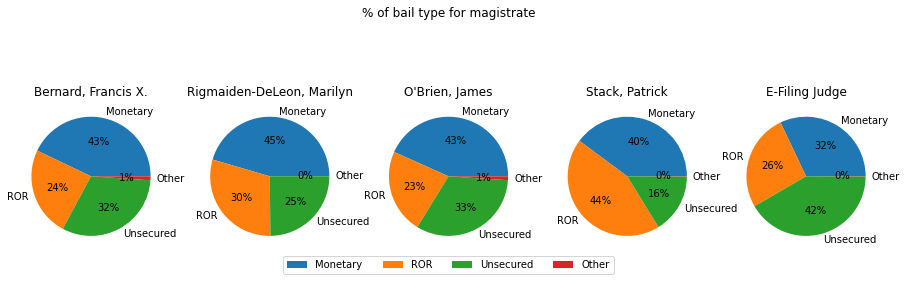

In [16]:
# Pie chart of core magistrates

# combine 'nominal' and 'nonmonetary' to 'other'
df_magistrate['Other'] = df_magistrate['Nominal'] + df_magistrate['Nonmonetary']

bail_types = ['Monetary','ROR', 'Unsecured', 'Other']
fig, ax = plt.subplots(ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(core_magistrates):
    ax[idx].pie(df_magistrate.loc[name, bail_types], labels = bail_types, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(-0.7, 0), ncol=4)

plt.show()

Q: Are bail type (monetary vs others) and magistrate related?  

In [17]:
# get column for non-monetary
df_magistrate['non_monetary'] = df_magistrate['Total'] - df_magistrate['Monetary']
df_chi = df_magistrate[['Monetary', 'non_monetary']]

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[core_magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  1.050701555979691e-12


* At significance level 0.01, chi-square test tells us that **bail type and magistrate are related.** 
* It's probably detecting the fact that bails set by E-Filing Judge is less likely to result in monetary bail, while bail set by Rigmaiden-DeLeon is more likely to result in monetary bail.

### 2.3 For monetary bail, does bail amount vary by magistrate? 

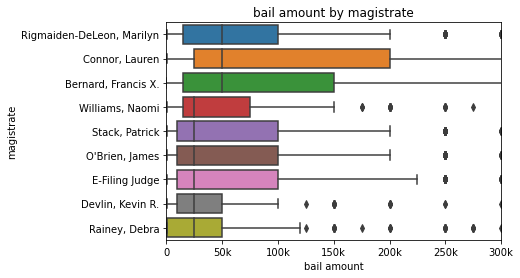

In [18]:
# plot bail amount (bar plot) by magistrate
df['magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['magistrate'] == 1)][['bail_set_by', 'bail_amount']]

# order by median amount
order = df_monetary.groupby(['bail_set_by']).bail_amount.median().sort_values(ascending = False).keys()

# plot
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], 
           order = order)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

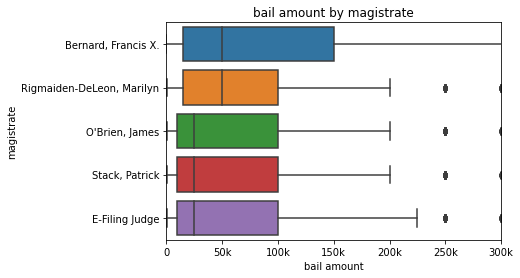

In [19]:
# plot bail amount (bar plot) for core magistrates
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

* It seems like Bernard and Rigmaiden-DeLeon sets higher bail amount than the others.
* To test this, either use t-test or Mann-Whitney U test  
* The following diagram shows that the distribution of bail amounts (for a fixed magistrate) is far from normal. Even log transform isn't enough. 
* We'll thus use Mann-Whitney U-test instead of t-test

Plot histogram of bail amount for a particular magistrate

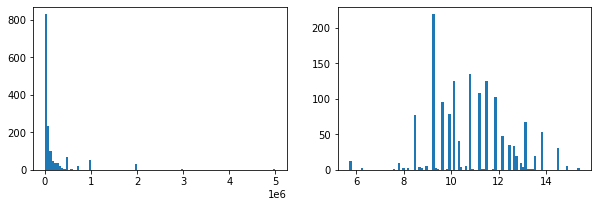

In [21]:
# ignore bail amount == 0
df_monetary = df[df['bail_type'] == 'Monetary'][['bail_set_by', 'bail_amount']]
df_monetary = df_monetary[df_monetary['bail_amount']!= 0]

# apply log transform
df_monetary['log_bail_amount'] = df_monetary['bail_amount'].apply(lambda x: np.log(x))

fig, ax = plt.subplots(ncols = 2, figsize = (10, 3))
ax[0].hist(df_monetary[df_monetary["bail_set_by"] == 'Bernard, Francis X.'].bail_amount, bins =100)
ax[1].hist(df_monetary[df_monetary["bail_set_by"] == 'Bernard, Francis X.'].log_bail_amount, bins =100)
plt.show()

* log transform doesn't help in getting the distribution to look normal.
* Instead of doing a t-test, we'll use a non-parametric test: Mann-Whitney U-test  
* Perform Mann-Whitney U-test on every pair of magistrates

In [22]:
# create order of magistrates
# note: the index was manually decided to make the correlation matrix look nice.

magistrate_order = ['Bernard, Francis X.',
                    'Rigmaiden-DeLeon, Marilyn',
                    'Stack, Patrick',
                    "O'Brien, James",
                    'E-Filing Judge',
                    'Williams, Naomi',
                    'Rainey, Debra',
                    'Connor, Lauren',
                    'Devlin, Kevin R.']

magistrate_index = {}
for idx, person in enumerate(magistrate_order):
    magistrate_index[person] = idx

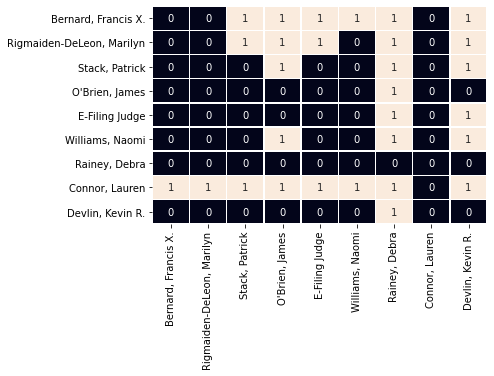

In [24]:
# matrix of differences
df_monetary = df[(df['bail_type'] == 'Monetary')][['bail_set_by', 'bail_amount']]
n_magistrates = len(magistrate_order)
diff_matrix = np.zeros((n_magistrates, n_magistrates))

for magistrate1 in magistrate_order:
    for magistrate2 in magistrate_order:
        if magistrate1 != magistrate2:
            # select data for two magistrates
            data1 = df_monetary[df_monetary['bail_set_by'] == magistrate1].bail_amount
            data2 = df_monetary[df_monetary['bail_set_by'] == magistrate2].bail_amount

            # Mann-Whitney U test 
            statistic, pvalue = mannwhitneyu(data1, data2, alternative = 'greater')
            
            # save p-values
            if pvalue < 0.01:
                idx1 = magistrate_index[magistrate1]
                idx2 = magistrate_index[magistrate2]

                diff_matrix[idx1, idx2] = 1
  
        
# plot
g = sns.heatmap(diff_matrix, linewidths=.5, annot = True, cbar = False)
g.set_xticklabels(magistrate_order, rotation = 90)
g.set_yticklabels(magistrate_order, rotation = 0)
plt.show()

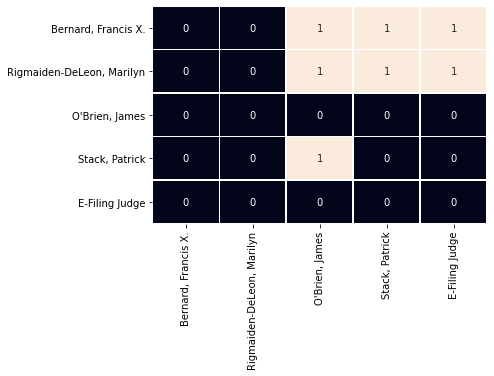

In [25]:
# matrix of differences (Just for core magistrates)
magistrate_index = {}
for idx, person in enumerate(core_magistrates):
    magistrate_index[person] = idx


df_monetary = df[(df['bail_type'] == 'Monetary')][['bail_set_by', 'bail_amount']]
n_magistrates = len(core_magistrates)
diff_matrix = np.zeros((n_magistrates, n_magistrates))

for magistrate1 in core_magistrates:
    for magistrate2 in core_magistrates:
        if magistrate1 != magistrate2:
            # select data for two magistrates
            data1 = df_monetary[df_monetary['bail_set_by'] == magistrate1].bail_amount
            data2 = df_monetary[df_monetary['bail_set_by'] == magistrate2].bail_amount

            # Mann-Whitney U test 
            statistic, pvalue = mannwhitneyu(data1, data2, alternative = 'greater')
            
            # save p-values
            if pvalue < 0.01:
                idx1 = magistrate_index[magistrate1]
                idx2 = magistrate_index[magistrate2]

                diff_matrix[idx1, idx2] = 1
  
        
# plot
g = sns.heatmap(diff_matrix, linewidths=.5, annot = True, cbar = False)
g.set_xticklabels(core_magistrates, rotation = 90)
g.set_yticklabels(core_magistrates, rotation = 0)
plt.show()

* Interpretation
    * If entry at particular row and column is white: Bail set by row-magistrate is likely to be higher than bail set by column-magistrate
    * If X: bail set by row magistrate, Y: bail set by column-magistrate, P(X>Y) > 0.5
* first row: Bail set by Bernard is likely to be higher than bail set by O'Brien, Stack, and E-Filing Judge
* second row: Bail set by Rigmaiden-DeLeon is likely to be higher than bail set by O'Brien, Stack, E-filing Judge
* third row: Bail set by Stack is likely to be higher than O'Brien
    * This was a bit confusing. See the following histogram

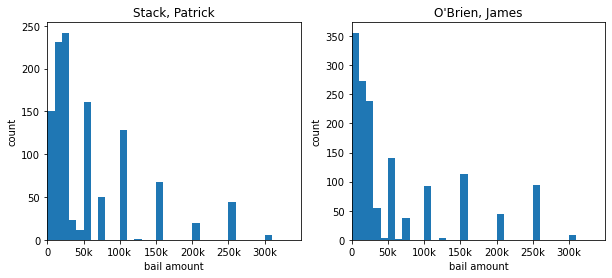

In [43]:
# why is there a difference between Stack and O'Brien?
bins = range(0, 350000, 10000)
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
ax[0].hist(df_monetary[df_monetary['bail_set_by'] == "Stack, Patrick"].bail_amount, bins = bins)
ax[0].set_title("Stack, Patrick")
ax[1].hist(df_monetary[df_monetary['bail_set_by'] == "O'Brien, James"].bail_amount, bins = bins)
ax[1].set_title("O'Brien, James")

for sub in ax.flat:
    sub.set_xlim((0, 350000))
    sub.set_xticks(range(0,350000,50000))
    sub.set_xticklabels(['0','50k','100k','150k','200k','250k','300k'])
    sub.set_xlabel('bail amount')
    sub.set_ylabel('count')
plt.show()

### 2.4 Are preliminary hearing date and time related to magistrates?

This may be relevant, as offense severity may depend on hearing time 

IndexError: index 2 is out of bounds for axis 0 with size 2

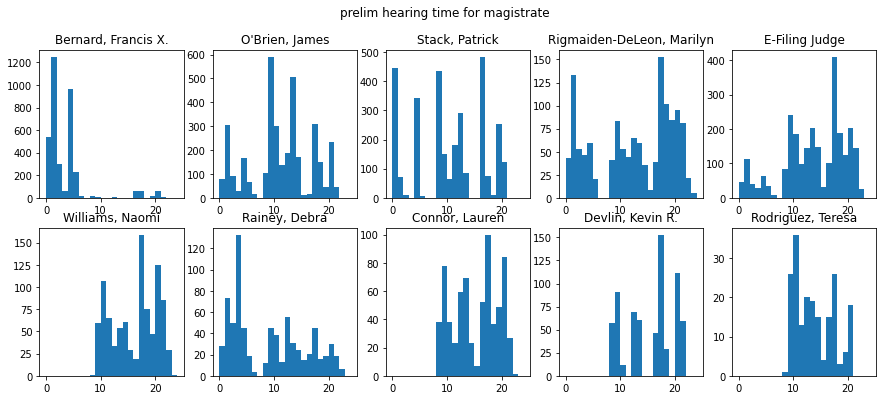

In [40]:
df['prelim_hearing_hour'] = df['prelim_hearing_time'].apply(lambda x: x.hour)
# prelim hearing time (hour) of each magistrate

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 6))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing time for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 5
    col = idx % 5 
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_hour, bins=24, range=(0,24))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xlim(0,24)
    sub.set_xlabel('prelim hearing time')
    sub.set_ylabel('case count')
plt.tight_layout()
plt.show()

### 2.5 Are specific magistrates more likely to handle specific types of offenses?

Use topic modeling to extract offense type (for now)
Options:
* TF-IDF
* LDA
* NMF


<b> Remove offenses with super long length </b>

In [41]:
# remove offenses with super long length
df['max_offense_length'] = df['offenses'].apply(lambda x: max([len(item) for item in x]))

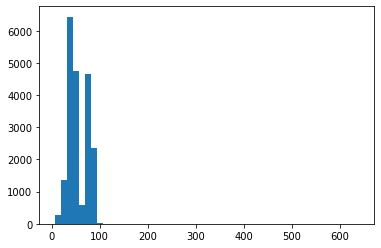

In [42]:
plt.hist(df['max_offense_length'], bins = 50)
plt.show()

In [43]:
# look at those with max offense length >= 200 
df_long = df[df['max_offense_length'] >= 200]

In [44]:
# remove offenses with long length
df['cleaned_offenses'] = df['offenses'].apply(lambda x: [item for item in x if len(item) < 200])

<b> topic modeling via NMF </b>

In [45]:
# prepare text (offenses)
corpus = df['cleaned_offenses'].apply(lambda x: ' '.join(x)).tolist()

# remove stop words
stopwords = ['for','a','of','the','and','to','in', 'or']

# corpus format: list of list
# lowercase
corpus = [[word for word in text.lower().split() if word not in stopwords] for text in corpus]

In [46]:
# create dictionary of worrds
dictionary = Dictionary(corpus)

In [47]:
# split to training and CV set 
n_documents = len(corpus)

total = list(range(n_documents))
random.shuffle(total)

train_size = int(n_documents * 0.7)
train_idx = total[:train_size]
cv_idx = total[train_size:]

# train document
train_doc = [corpus[idx] for idx in train_idx]
cv_doc = [corpus[idx] for idx in cv_idx]

# prepare corpus
train_corpus = [dictionary.doc2bow(text) for text in train_doc]
cv_corpus = [dictionary.doc2bow(text) for text in cv_doc]
total_corpus = [dictionary.doc2bow(text) for text in corpus]

print('number of training set: ', len(train_idx))
print('number of cv set: ', len(cv_idx))

number of training set:  14298
number of cv set:  6128


In [48]:
# compute coherence scores for NMF models of various topic numbers
topic_numbers = list(range(5,30))
scores = {}

for k in topic_numbers:
    # train NMF model
    nmf = Nmf(train_corpus, id2word = dictionary, num_topics = k)
    
    # compute coherence on cv
    cm = CoherenceModel(model=nmf, texts=cv_doc, window_size = 50, coherence='c_uci')
    coherence = cm.get_coherence() 
    scores[k] = coherence

/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/anaconda3/lib/python3.6/site-pack

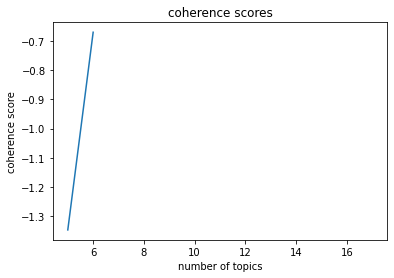

In [49]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence scores')
plt.show()

It seems like coherence score is maximized when number of topics is 15 
Q: Why is the coherence score not computed for some topic numbers?

In [50]:
# train NMF model
nmf = Nmf(total_corpus, id2word = dictionary, num_topics = 15)

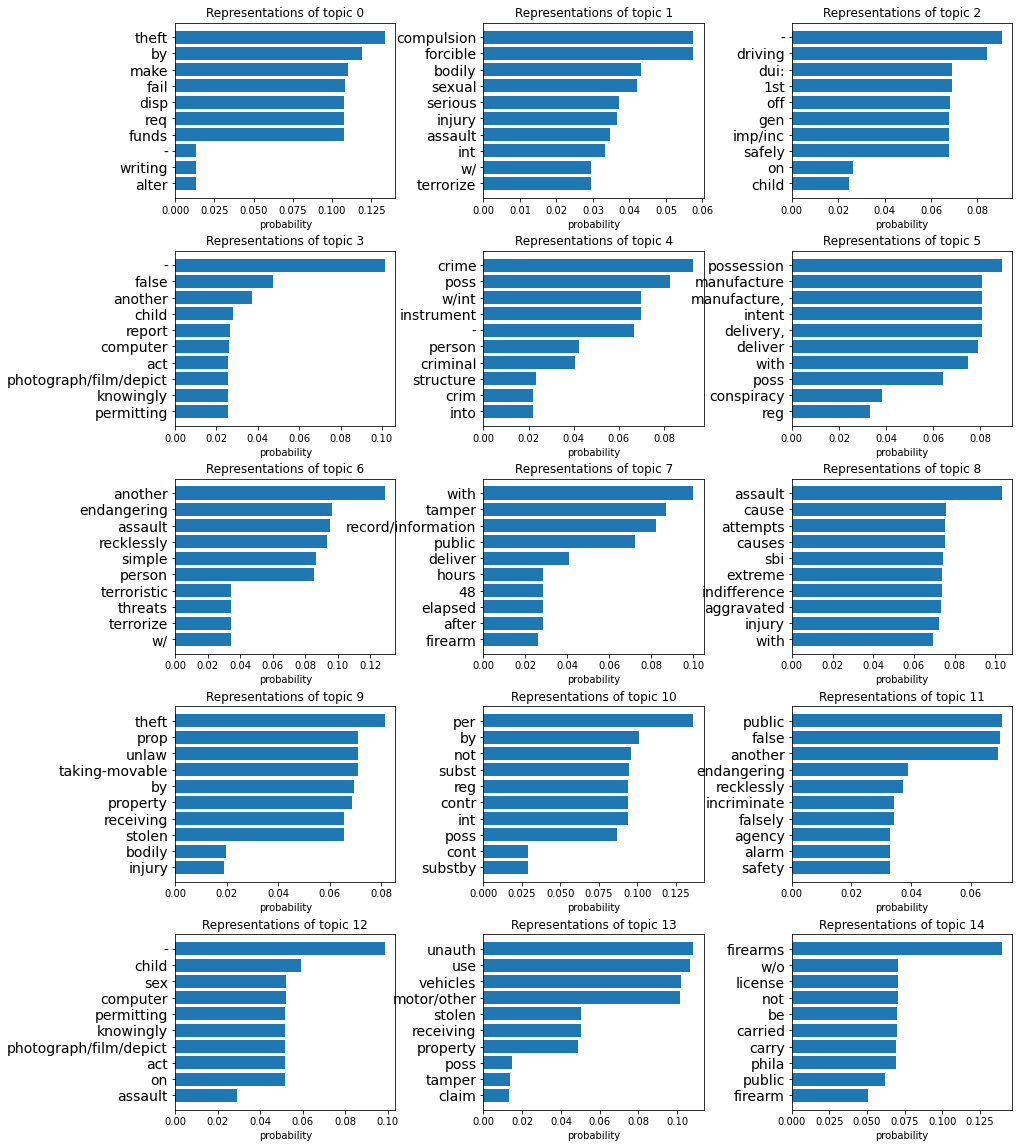

In [51]:
# Visualize topic representations for 4 (out of 15) topics
fig, ax = plt.subplots(nrows = 5, ncols = 3, figsize = (15, 20))

for i in range(15):
    row = i // 3
    col = i % 3
    
    topic_rep = nmf.show_topic(i)
    words = [item[0] for item in topic_rep][::-1]
    prob = [item[1] for item in topic_rep][::-1]
    
    ax[row][col].barh(words, prob)
    ax[row][col].tick_params(axis="y", labelsize=14)
    ax[row][col].set_xlabel('probability')
    ax[row][col].set_title('Representations of topic '+ str(i))
    
fig.subplots_adjust(wspace=0.4, hspace = 0.3)
plt.show()

In [52]:
# save NMF model
#nmf.save('offenses_nmf')

# to load
nmf = Nmf.load('offenses_nmf')

In [53]:
# for each offense, assign topic number 
topic_numbers = []

for case in total_corpus:
    topics = nmf[case]
    topic_num = [item[0] for item in topics]
    topic_prob = [item[1] for item in topics]
    topic_numbers.append(topic_num[topic_prob.index(max(topic_prob))])

In [54]:
# create column of offense type
df['topic_numbers'] = topic_numbers

# create dummy variables
#df = pd.concat([df, pd.get_dummies(df['topic_numbers'], prefix = 'offense_')], axis=1)

<b> Q: Are there correlations between offense type and magistrate? </b>

In [55]:
df_magistrate_offense = pd.crosstab(index = df['bail_set_by'], columns =df['topic_numbers'])
df_magistrate_offense['Total'] = df_magistrate_offense.sum(axis = 1)

In [56]:
df_magistrate_offense.loc[core_magistrates]

topic_numbers,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Total
bail_set_by,,,,,,,,,,,,,,,,
"Bernard, Francis X.",1083,26,115,90,298,73,66,41,257,313,178,8,113,16,903,3580
E-Filing Judge,604,33,107,100,214,59,45,45,268,224,139,5,104,19,705,2671
"Stack, Patrick",833,29,102,79,214,62,42,34,286,207,184,10,107,29,811,3029
"O'Brien, James",970,28,129,89,266,54,40,33,344,318,280,8,100,31,880,3570


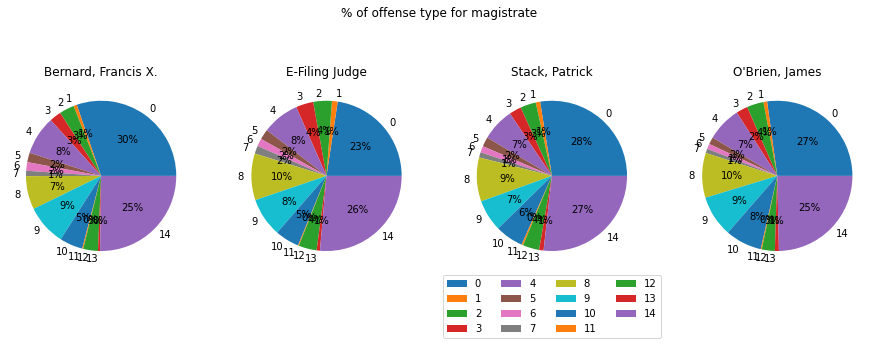

In [57]:
# visualize

topic_nums = list(range(15))

fig, ax = plt.subplots(ncols = 4, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of offense type for magistrate')
for idx, name in enumerate(core_magistrates):

    ax[idx].pie(df_magistrate_offense.loc[name, topic_nums], labels = topic_nums, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.show()

From what we see above, each magistrate seems to handle similar proportions of offense types

In [58]:
# test
df_chi = df_magistrate_offense.drop(columns = ['Total'])

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[core_magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  2.079951120406998e-14


From the above, it's kind of hard to tell why we get a significant result. we may need more specific tests

<b>To do</b>: Do chi-square test for each topic number as following: topic i vs non-topic i

In [59]:
def chisquare_by_topic(df_magistrate_offense, topic_num, magistrates):
    df_chi = df_magistrate_offense.loc[magistrates]
    df_chi['not'] = df_chi['Total'] - df_chi[topic_num]
    # chi-squared test"
    chi2, p, dof, ex = chi2_contingency(df_chi[[topic_num, 'not']])\n
    return p

SyntaxError: unexpected character after line continuation character (<ipython-input-59-9f9d13ea3288>, line 5)

In [60]:
# example for topic 1
df_chi = df_magistrate_offense.loc[core_magistrates]
df_chi['not_1'] = df_chi['Total'] - df_chi[1]

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi[[1, 'not_1']])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  0.15682727272824448


### 2.6 Predict bail type and bail amount. Find the important factors

## 3. Which neighborhoods are heavily impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


### Basically a reproduction of some of the above with some interactive elements.

I can add even more filters if there's a good reason to do so. Also might need to do something to handle certain Metric/Type combos (as Bail Amount/Paid is N/A for some bail types).

#### Setting up data for viz

In [61]:
# Create data assoc. w/ each metric (over all bail types) and put in dict
case_counts = pd.DataFrame(df['zip'].value_counts().reset_index().rename(columns={'index': 'zip', 'zip': 'count'}))
bail_amounts = df.groupby('zip').sum()[['bail_amount']].reset_index()
bail_paid = df.groupby('zip').sum()[['bail_paid']].reset_index()
cases_dfs = {'Case Count': case_counts, 'Bail Amount': bail_amounts, 'Bail Paid': bail_paid}

In [62]:
# Same as above but also filtering by bail type
case_counts_by_type = df.groupby(['zip', 'bail_type']).\
                    size().unstack(fill_value=0).stack().reset_index().rename(columns={0: 'count'})
bail_amounts_by_type = df.groupby(['zip', 'bail_type']).sum().unstack(fill_value=0).\
                    stack()[['bail_amount']].reset_index()
bail_paid_by_type = df.groupby(['zip', 'bail_type']).sum().unstack(fill_value=0).\
                    stack()[['bail_paid']].reset_index()
type_dfs = {'Case Count': case_counts_by_type, 'Bail Amount': bail_amounts_by_type, 'Bail Paid': bail_paid_by_type}

In [63]:
# Geo data
# Approximate Philly lat/long
philly = (40.00, -75.16)

# Open geojson of philly zip code borders
zips_geo = 'Zipcodes_Poly.geojson'
with open(zips_geo) as f:
    zips_data = json.load(f)

#### Setting up viz

In [72]:
# Unique bail types, remove 'nan'
types = df[df['bail_type'].notnull()]['bail_type'].unique().tolist()

# Dropdown menu for metrics
metrics = widgets.Dropdown(
    options=['Case Count', 'Bail Amount', 'Bail Paid'],
    value='Case Count',
    description='Metric'
)

# Dropdown menu for bail type
types = widgets.Dropdown(
    options=['All']+types,
    value='All',
    description='Bail Type',
)

# Set up figure object (choropleth map) with our geo data
map_fig = go.FigureWidget(go.Choroplethmapbox(geojson=zips_data, # geojson data
                                          z=bail_amounts['bail_amount'], # what colors will rep. in map from our data
                                          locations=bail_amounts['zip'], # zip codes in our data
                                          featureidkey="properties.CODE", # key index in geojson for zip
                                         ))
map_fig.update_layout(mapbox_style="carto-positron",
                   mapbox_zoom=9.75, mapbox_center = {"lat": philly[0], "lon": philly[1]})
map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Function that updates map based on dropdown selections
def response(change):
    if types.value == 'All':
        df = cases_dfs[metrics.value]
        map_fig.data[0].z = df[df.columns[1]]
        map_fig.data[0].locations = df[df.columns[0]]
    else:
        df = type_dfs[metrics.value].loc[type_dfs[metrics.value]['bail_type'] == types.value]
        map_fig.data[0].z = df[df.columns[2]]
        map_fig.data[0].locations = df[df.columns[0]]

# Set up dropdowns to update map
metrics.observe(response, names='value')
types.observe(response, names='value')

widgets.VBox([widgets.HBox([metrics, types]), map_fig])

## 4. Break down by race (and gender/age?)
For all bail:
- Raw numbers for race/sex and bail type
- Are race and bail type correlated? (for comparable offense types?)
- Same for gender and age

For monetary bail:
- Histogram of race/sex and bail amount
- Are race and bail amount correlated? (for comparable offense types?)
- Same for gender and age

Most generally: what are the strongest factors determining bail type and bail amount?
- Do a predictive modeling (e.g., regression, decision trees, random forest) and feature importance analysis
- Possible factors: race, age, sex; offense types, offense number; magistrate, arresting officer; public/private defender

In [32]:
df['sex'].value_counts()

# exclude Unreported/Unknown (too small a sample to derive conclusions from)

Male                  17128
Female                 3294
Unreported/Unknown        1
Name: sex, dtype: int64

In [33]:
df['bail_type'].value_counts()

# exclude Nominal 

Monetary       8744
ROR            5627
Unsecured      5599
Nonmonetary     122
Nominal           4
Name: bail_type, dtype: int64

In [34]:
df['race'].value_counts()

# exclude Unknown/Unreported, Native American/Alaskan Native, Bi-Racial

Black                             13570
White                              6603
Asian/Pacific Islander              178
Unknown/Unreported                   49
Native American/Alaskan Native       15
Bi-Racial                             2
Name: race, dtype: int64

In [35]:
df['age'] = df['dob'].apply(lambda x: datetime.date.today().year - x.year)

df['age'].describe()

count    20422.000000
mean        34.011703
std         11.885412
min         14.000000
25%         25.000000
50%         31.000000
75%         41.000000
max        120.000000
Name: age, dtype: float64

In [36]:
def bin_age(age):
    if age < 18:
        return 'minor'
    elif age < 26:
        return '18 to 25'
    elif age < 34:
        return '26 to 33'
    elif age < 42:
        return '34 to 41'
    elif age < 50:
        return '42 to 49'
    elif age < 58:
        return '50 to 57'
    elif age < 65:
        return '58 to 64'
    else:
        return 'senior'
    
df['age_group'] = df['age'].apply(lambda x: bin_age(x))

In [37]:
df['age_group'].value_counts()

26 to 33    6129
18 to 25    5413
34 to 41    4113
42 to 49    2229
50 to 57    1529
58 to 64     700
senior       246
minor         67
Name: age_group, dtype: int64

In [38]:
race_filter = (df['race'] != 'Unknown/Unreported') & (df['race'] != 'Native American/Alaskan Native') & (df['race'] != 'Bi-Racial')
sex_filter = (df['sex'] != 'Unreported/Unknown')
bail_type_filter = (df['bail_type'] != 'Nominal')

### 4.1 Bail Type Breakdown

<AxesSubplot:xlabel='bail_type', ylabel='count'>

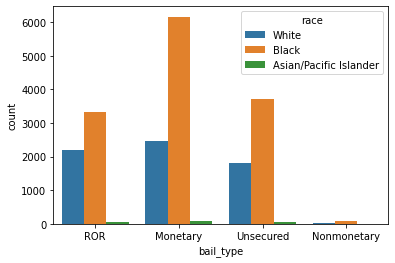

In [39]:
sns.countplot(data = df[race_filter & bail_type_filter], x='bail_type', hue='race')

<AxesSubplot:xlabel='bail_type', ylabel='count'>

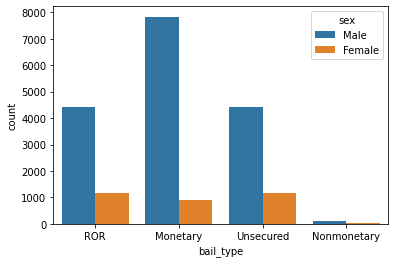

In [40]:
sns.countplot(data = df[sex_filter & bail_type_filter], x='bail_type', hue='sex')

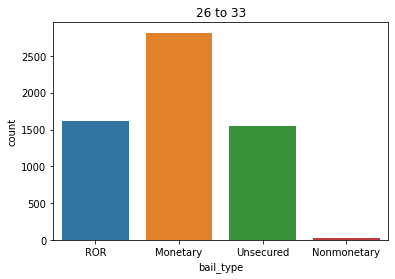

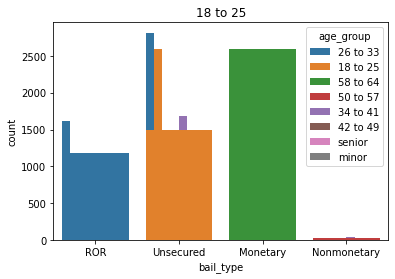

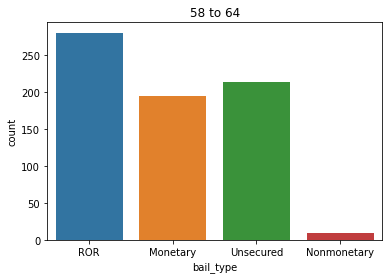

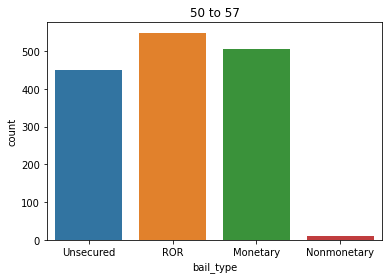

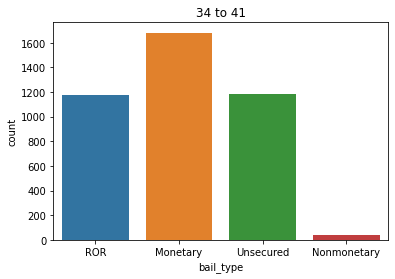

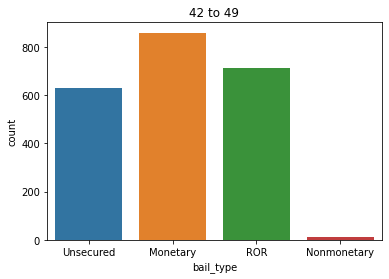

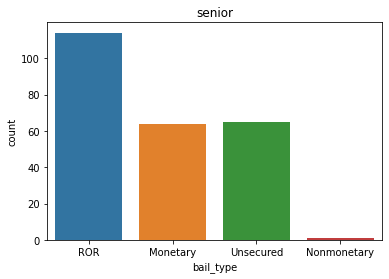

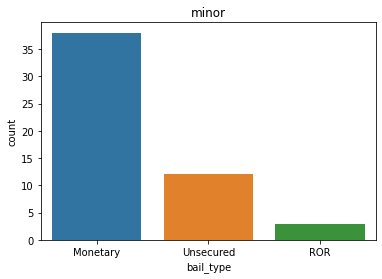

In [45]:
sns.countplot(data = df[bail_type_filter], x='bail_type', hue='age_group')

for i, age_group in enumerate(df['age_group'].unique()):
    plt.figure(i)
    plt.title(age_group)
    sns.countplot(data = df[bail_type_filter & (df['age_group'] == age_group)], x = 'bail_type')
    
# code block needs to be fixed

### 4.? Predictive Modeling

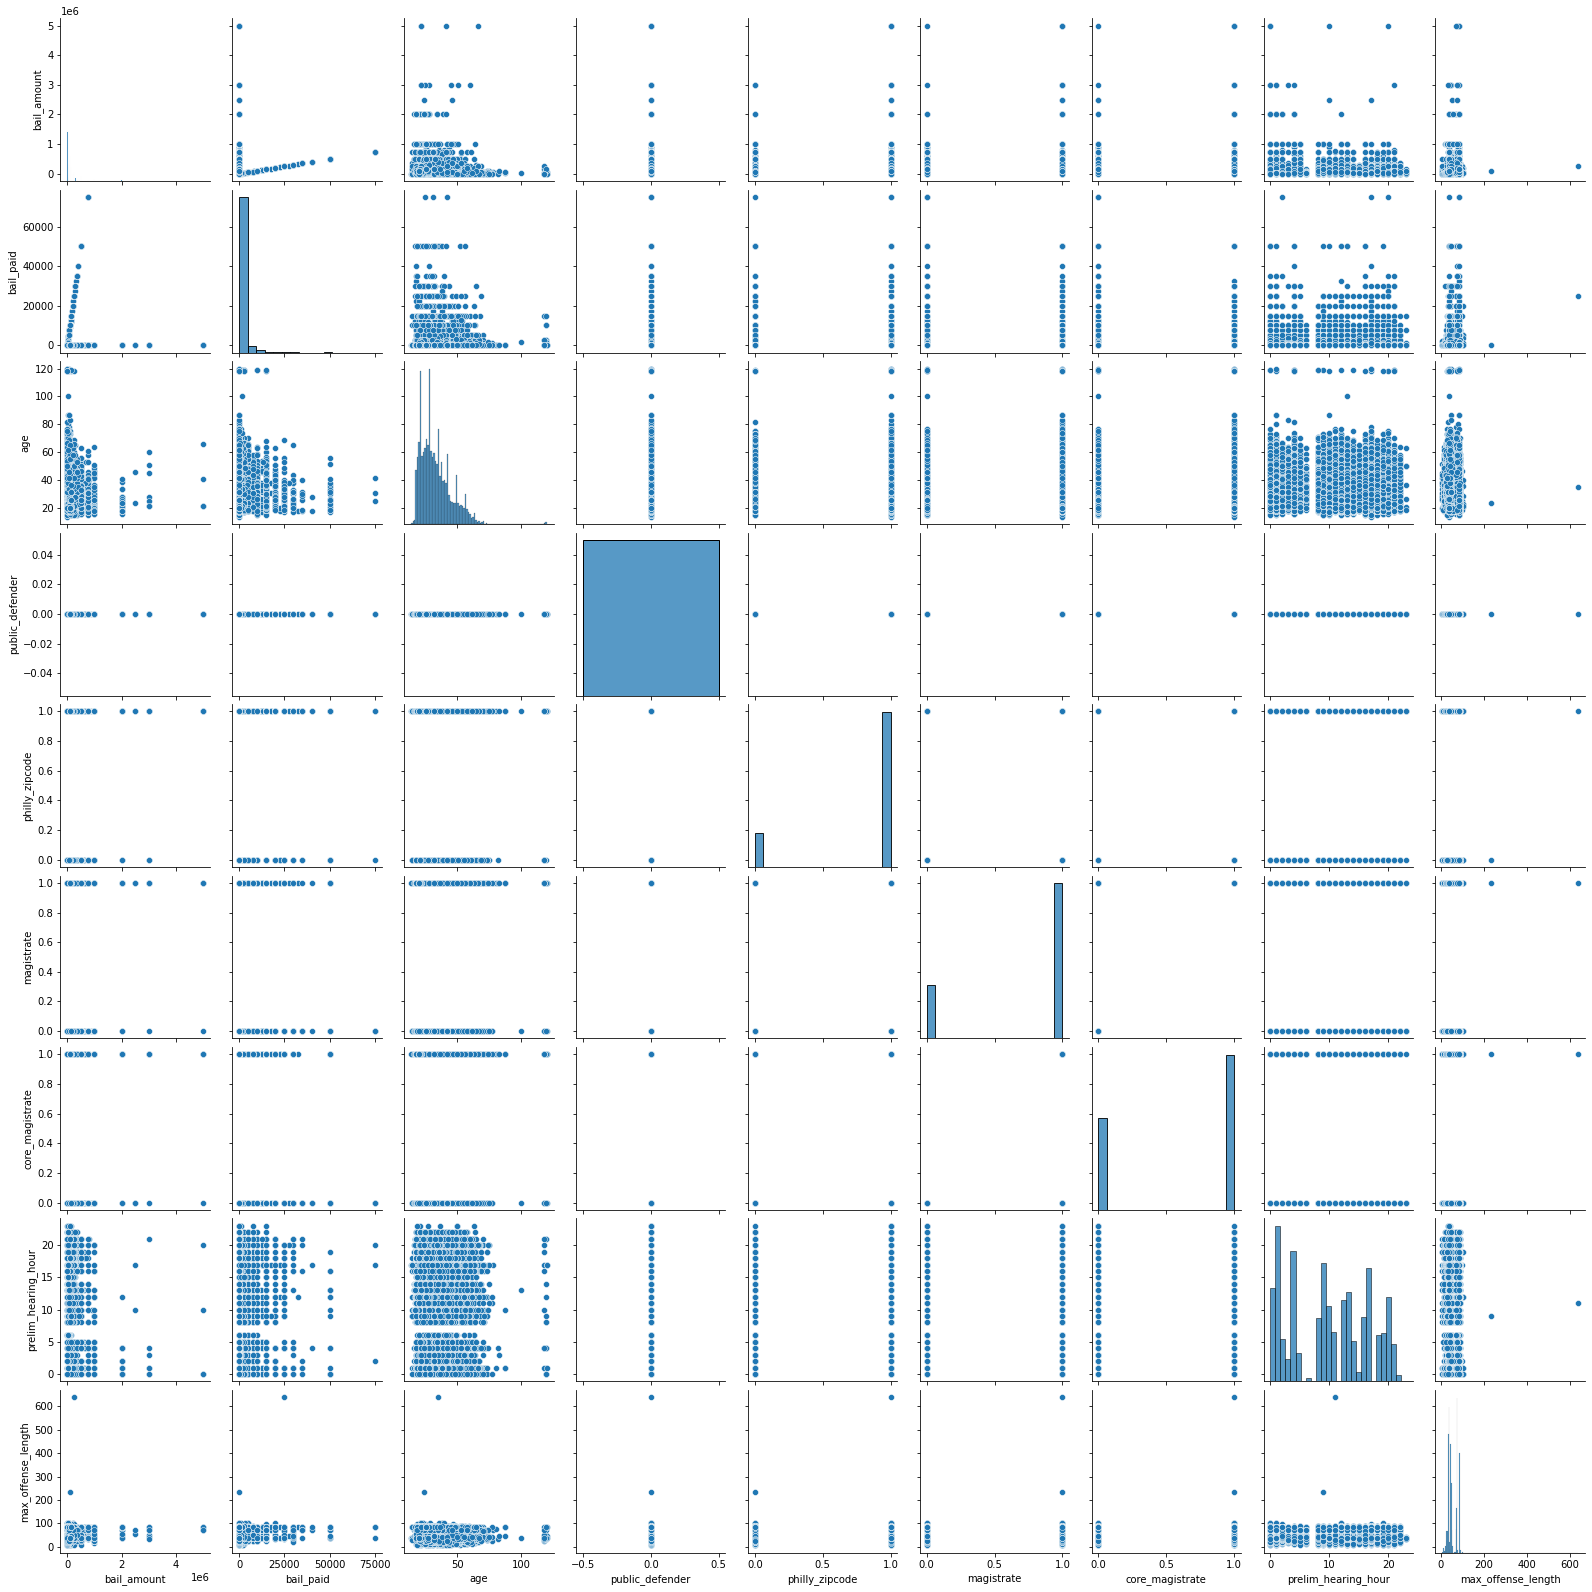

In [34]:
sns.pairplot(df)

## 5. How much Philadelphians paid in bail 
(see 1)

In [73]:
monetary_bail = df[df['bail_type']=='Monetary']

monetary_bail_total = monetary_bail['bail_amount'].sum()
monetary_bail_paid = monetary_bail['bail_paid'].sum()

print('The total bail amount is ${:,.0f}, while the bail paid is ${:,.0f} which comprises of {:.2f}%'.format(
    monetary_bail_total, monetary_bail_paid, (monetary_bail_paid/monetary_bail_total)*100
))

The total bail amount is $879,302,493, while the bail paid is $19,631,035 which comprises of 2.23%


### 5.1 Summary Stats

**Summary statistics of bail amount**

In [74]:
monetary_bail['bail_amount'].describe()

count    8.744000e+03
mean     1.005607e+05
std      2.295750e+05
min      0.000000e+00
25%      1.000000e+04
50%      3.000000e+04
75%      1.000000e+05
max      5.000000e+06
Name: bail_amount, dtype: float64

In [75]:
monetary_bail['bail_amount'].value_counts(bins=10)

(-5000.001, 500000.0]     8542
(500000.0, 1000000.0]      156
(1500000.0, 2000000.0]      34
(2500000.0, 3000000.0]       7
(4500000.0, 5000000.0]       3
(2000000.0, 2500000.0]       2
(4000000.0, 4500000.0]       0
(3500000.0, 4000000.0]       0
(3000000.0, 3500000.0]       0
(1000000.0, 1500000.0]       0
Name: bail_amount, dtype: int64

In [76]:
monetary_bail['bail_amount'].value_counts()

# mode is $25K

25000.0     1082
50000.0     1036
10000.0      913
100000.0     657
5000.0       619
            ... 
510000.0       1
30300.0        1
325000.0       1
420000.0       1
15100.0        1
Name: bail_amount, Length: 96, dtype: int64

**Summary statistics of bail paid**

In [77]:
monetary_bail['bail_paid'].describe()

count     8744.000000
mean      2245.086345
std       4917.802319
min          0.000000
25%          0.000000
50%        500.000000
75%       2500.000000
max      75000.000000
Name: bail_paid, dtype: float64

In [78]:
monetary_bail['bail_paid'].value_counts(bins=10)

(-75.001, 7500.0]     8138
(7500.0, 15000.0]      433
(22500.0, 30000.0]      76
(15000.0, 22500.0]      66
(45000.0, 52500.0]      18
(30000.0, 37500.0]       8
(67500.0, 75000.0]       3
(37500.0, 45000.0]       2
(60000.0, 67500.0]       0
(52500.0, 60000.0]       0
Name: bail_paid, dtype: int64

In [79]:
monetary_bail['bail_paid'].value_counts()

0.0        4074
2500.0      753
1000.0      652
5000.0      583
500.0       446
           ... 
27500.0       1
25.0          1
32500.0       1
5030.0        1
1550.0        1
Name: bail_paid, Length: 66, dtype: int64

### 5.2 Bail Amount vs. Bail Paid Across Offense Types

In [ ]:
# requires nmf topic modeling results